# **Evolutionary Strategies**


In [ ]:
pip install deap

     |████████████████████████████████| 160 kB 2.3 MB/s 


In [ ]:
import numpy as np

import array, random, time, copy
from deap import base, creator, benchmarks, tools, algorithms

from matplotlib import cm
import matplotlib.pyplot as plt

random.seed(42)

In [ ]:
def plot_problem_3d(problem, bounds, resolution=100., 
                    cmap=cm.viridis_r, rstride=10, cstride=10, 
                    linewidth=0.15, alpha=0.65, ax=None):
    'Plots a given deap benchmark problem in 3D mesh.'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]
    
    if not ax:
        fig = plt.figure(figsize=(11,6))
        ax = fig.gca(projection='3d')
        
    cset = ax.plot_surface(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)

In [ ]:
def plot_problem_controur(problem, bounds, optimum=None,
                          resolution=100., cmap=cm.viridis_r, 
                          rstride=1, cstride=10, linewidth=0.15,
                          alpha=0.65, ax=None):
    'Plots a given deap benchmark problem as a countour plot'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]
    
    if not ax:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        ax.set_aspect('equal')
        ax.autoscale(tight=True)
    
    cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)
    
    if optimum:
        ax.plot(optimum[0], optimum[1], 'bx', linewidth=4, markersize=15)

In [ ]:
def plot_cov_ellipse(pos, cov, volume=.99, ax=None, fc='lightblue', ec='darkblue', alpha=1, lw=1):
    ''' Plots an ellipse that corresponds to a bivariate normal distribution.
    Adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/'''
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':alpha, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)
    ax.add_artist(ellip)

# **Benchmarks**
DEAP has a number of test problems already implemented. See http://deap.readthedocs.org/en/latest/api/benchmarks.html

### [Bohachevsky benchmark problem](http://deap.readthedocs.org/en/latest/api/benchmarks.html#deap.benchmarks.bohachevsky)

$$\text{minimize } f(\mathbf{x}) = \sum_{i=1}^{N-1}(x_i^2 + 2x_{i+1}^2 - 0.3\cos(3\pi x_i) - 0.4\cos(4\pi x_{i+1}) + 0.7), \mathbf{x}\in \left[-100,100\right]^n,$$

> Optimum in $\mathbf{x}=\mathbf{0}$, $f(\mathbf{x})=0$.

In [ ]:
current_problem = benchmarks.bohachevsky

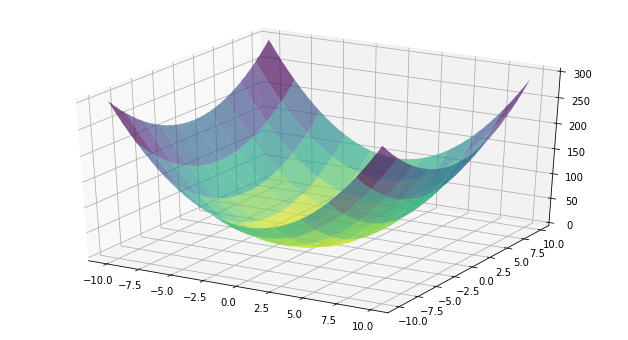

In [ ]:
plot_problem_3d(current_problem, ((-10,-10), (10,10)))

The Bohachevsky problem has many local optima.

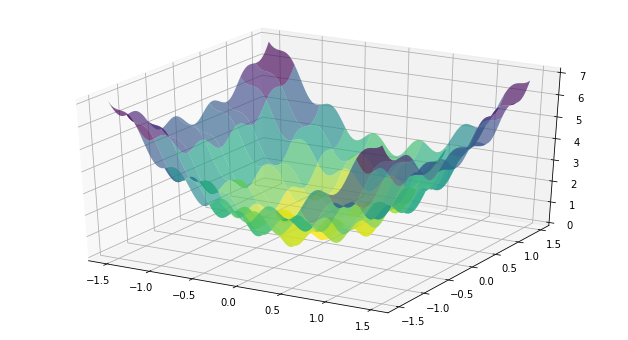

In [ ]:
plot_problem_3d(current_problem, ((-1.5,-1.5), (1.5,1.5)))

## ($\mu$,$\lambda$) evolutionary strategy


In [ ]:
search_space_dims = 2 # we want to plot the individuals so this must be 2

MIN_VALUE, MAX_VALUE = -10., 10.
MIN_STRAT, MAX_STRAT = 0.0000001, 1. 

In [ ]:
# We are facing a minimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Evolutionary strategies need a location (mean)
creator.create("Individual", array.array, typecode='d', 
               fitness=creator.FitnessMin, strategy=None)
# ...and a value of the strategy parameter.
creator.create("Strategy", array.array, typecode="d")

In [ ]:
def init_univariate_es_ind(individual_class, strategy_class,
                           size, min_value, max_value, 
                           min_strat, max_strat):
    ind = individual_class(random.uniform(min_value, max_value) 
                           for _ in range(size))
    # we modify the instance to include the strategy in run-time.
    ind.strategy = strategy_class(random.uniform(min_strat, max_strat) for _ in range(size))
    return ind

In [ ]:
toolbox = base.Toolbox() 
toolbox.register("individual", init_univariate_es_ind, 
                 creator.Individual, 
                 creator.Strategy,
                 search_space_dims, 
                 MIN_VALUE, MAX_VALUE, 
                 MIN_STRAT, MAX_STRAT)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [ ]:
ind = toolbox.individual()
pop = toolbox.population(n=3)

In [ ]:
def plot_individual(individual, ax=None):
    'Plots an ES indiviual as center and 3*sigma ellipsis.'
    cov = np.eye(len(individual)) * individual.strategy
    plot_cov_ellipse(individual, cov, volume=0.99, alpha=0.56, ax=ax)
    if ax:
        ax.scatter(individual[0], individual[1], 
                    marker='+', color='k', zorder=100)
    else:
        plt.scatter(individual[0], individual[1], 
                    marker='+', color='k', zorder=100)

    
def plot_population(pop, gen=None, max_gen=None, ax=None):
    if gen:
        plt.subplot(max_gen, 1, gen)
        
    for ind in pop:
        plot_individual(ind, ax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'


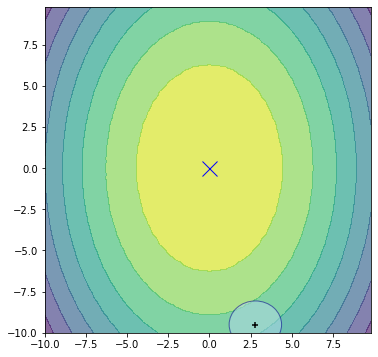

In [ ]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_individual(ind)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'


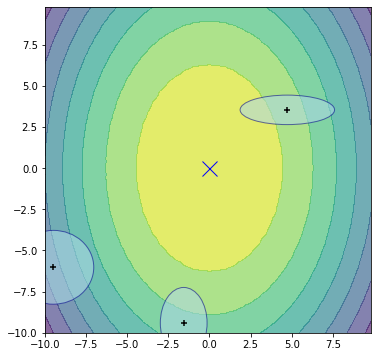

In [ ]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

### Mutation of an evolution strategy individual according to its strategy attribute. 
First the strategy is mutated according to an extended log normal rule, 
$$
\boldsymbol{\sigma}_t = \exp(\tau_0 \mathcal{N}_0(0, 1)) \left[ \sigma_{t-1, 1}\exp(\tau
\mathcal{N}_1(0, 1)), \ldots, \sigma_{t-1, n} \exp(\tau
\mathcal{N}_n(0, 1))\right],
$$
with 
$$\tau_0 =
\frac{c}{\sqrt{2n}}\text{ and }\tau = \frac{c}{\sqrt{2\sqrt{n}}},
$$

the individual is mutated by a normal distribution of mean 0 and standard deviation of $\boldsymbol{\sigma}_{t}$ (its current strategy). 

A recommended choice is $c=1$ when using a $(10,100)$ evolution strategy.

In [ ]:
toolbox.register("mutate", tools.mutESLogNormal, c=1, indpb=0.1)

Blend crossover on both, the individual and the strategy.

In [ ]:
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("evaluate", current_problem)
toolbox.register("select", tools.selBest)

In [ ]:
mu_es, lambda_es = 3,21

pop = toolbox.population(n=mu_es)
hof = tools.HallOfFame(1)

pop_stats = tools.Statistics(key=copy.deepcopy)
pop_stats.register('pop', copy.deepcopy) # -- copies the populations themselves
    
pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=mu_es, lambda_=lambda_es, 
        cxpb=0.6, mutpb=0.3, ngen=40, stats=pop_stats, halloffame=hof, verbose=False)

### The final population

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'


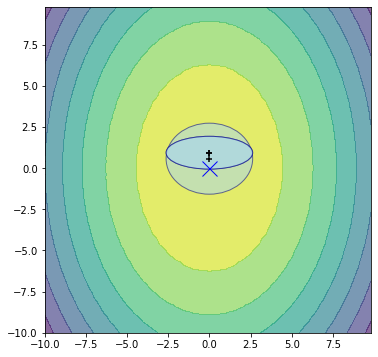

In [ ]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

The plot (most probably) shows a "dark blue" ellipse as all individuals are overlapping. 